In [2]:
import os
import sys
os.getpid()

sys.path.append(r'C:\Users\PC\source\repos\MySLVCalibration\x64\Release')


✅ Load module C++ thành công!
Generating synthetic SVI parameters...

[C++] Bootstrapping Local Volatility Surface...
✅ Bootstrap finished in 6.8321 seconds

[C++] Running SLV Particle Calibration...
✅ Calibration finished in 0.2285 seconds


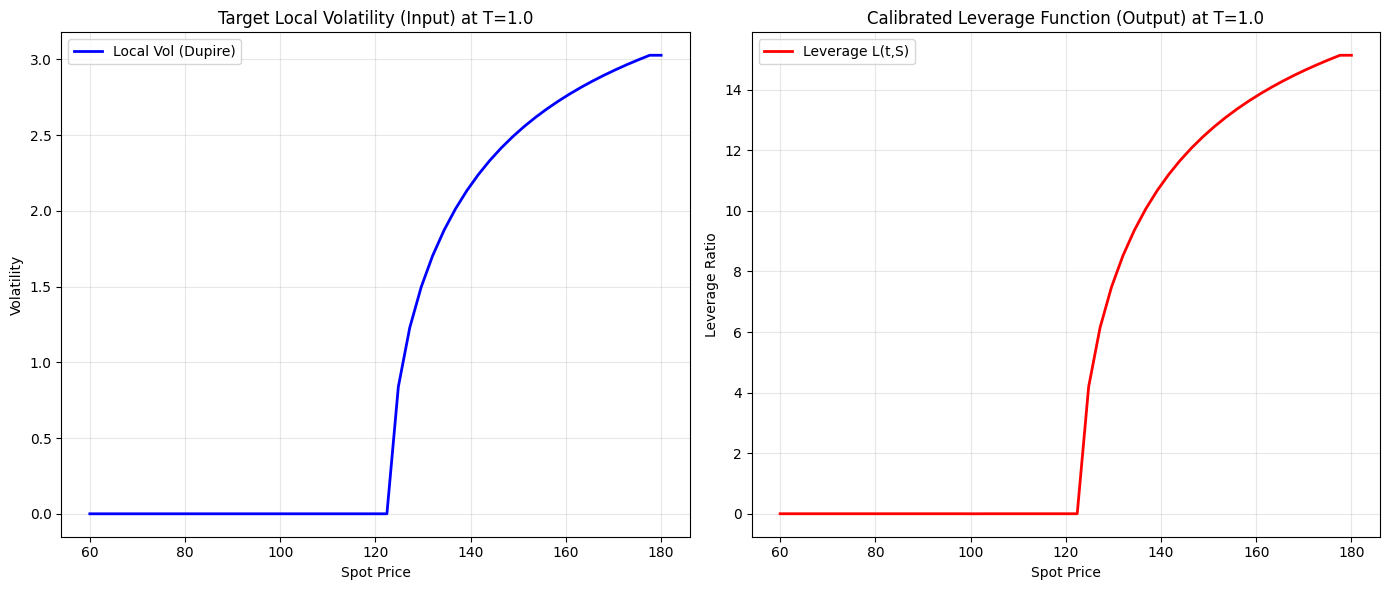

In [ ]:

import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt


try:
    import slv_engine
    print("✅ Load module C++ thành công!")
except ImportError as e:
    print("❌ Không tìm thấy module 'slv_engine'. Hãy kiểm tra lại đường dẫn file .pyd")
    raise e

market_params = {
    's0': 100.0, 'r': 0.02, 'q': 0.01,
    't_grid': np.linspace(0.0, 1.0, 21), 
    's_grid': np.linspace(60.0, 180.0, 51)
}


heston_dict = {'v0': 0.04, 'kappa': 2.0, 'theta': 0.04, 'xi': 0.5, 'rho': -0.7}


heston_process = slv_engine.HestonProcess(
    slv_engine.HestonParams(
        heston_dict['v0'], 
        heston_dict['kappa'], 
        heston_dict['theta'], 
        heston_dict['xi'], 
        heston_dict['rho']
    )
)

numerical_params = {
    'T': 1.0, 'M': 20, 'N': 50000 
}


print("Generating synthetic SVI parameters...")
# Format: Maturity -> (a, b, rho, m, sigma)
true_svi_params = {
    0.25: (0.04, 0.2, -0.8, 0.1, 0.3),
    0.50: (0.05, 0.18, -0.75, 0.05, 0.25),
    1.00: (0.06, 0.15, -0.7, 0.0, 0.2)
}

print("\n[C++] Bootstrapping Local Volatility Surface...")
start_time = time.time()


dummy_surface = [[0.2] * len(market_params['s_grid'])] * len(market_params['t_grid'])

temp_market = slv_engine.MarketData(
    market_params['s0'], market_params['r'], market_params['q'],
    market_params['t_grid'], market_params['s_grid'], dummy_surface
)

bootstrapper = slv_engine.LocalVolBootstrapper(temp_market)

for t, p in true_svi_params.items():
    
    svi_cpp = slv_engine.SVIParams(p[0], p[1], p[2], p[3], p[4])
    bootstrapper.add_slice(t, svi_cpp)

target_lv_surface = bootstrapper.bootstrap()

end_time = time.time()
print(f"✅ Bootstrap finished in {end_time - start_time:.4f} seconds")

print("\n[C++] Running SLV Particle Calibration...")

real_market = slv_engine.MarketData(
    market_params['s0'], market_params['r'], market_params['q'],
    market_params['t_grid'], market_params['s_grid'], 
    target_lv_surface # <-- Surface từ C++ trả về (đã auto convert sang list)
)

calibrator = slv_engine.SLVCalibrator(
    real_market, 
    heston_process, 
    numerical_params['T'], 
    numerical_params['M'], 
    numerical_params['N'], 
    market_params['s_grid']
)


start_time = time.time()
leverage_surface = calibrator.calibrate()
end_time = time.time()

print(f"✅ Calibration finished in {end_time - start_time:.4f} seconds")


lv_arr = np.array(target_lv_surface)
lev_arr = np.array(leverage_surface)
s_grid = market_params['s_grid']

time_idx = -1 
t_val = market_params['t_grid'][time_idx]

plt.figure(figsize=(14, 6))

# Plot 1: Local Volatility Surface (Target)
plt.subplot(1, 2, 1)
plt.plot(s_grid, lv_arr[time_idx, :], label='Local Vol (Dupire)', color='blue', linewidth=2)
plt.title(f'Target Local Volatility (Input) at T={t_val}')
plt.xlabel('Spot Price')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Leverage Function (Output)
plt.subplot(1, 2, 2)
plt.plot(s_grid, lev_arr[time_idx, :], label='Leverage L(t,S)', color='red', linewidth=2)
plt.title(f'Calibrated Leverage Function (Output) at T={t_val}')
plt.xlabel('Spot Price')
plt.ylabel('Leverage Ratio')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

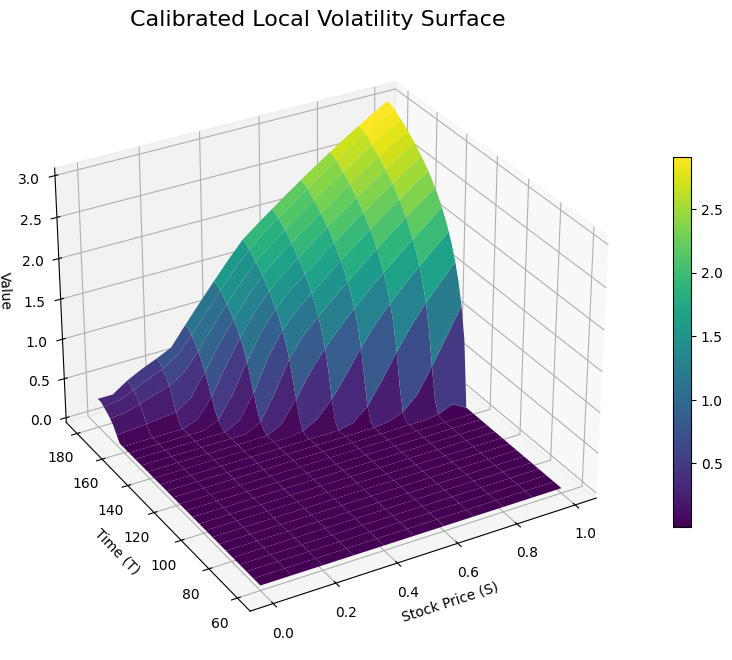

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_surface(X, Y, Z, title, z_label='Value'):
    """Helper function to plot a 3D surface."""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X_grid, Y_grid = np.meshgrid(X, Y)
    surf = ax.plot_surface(X_grid, Y_grid, Z.T, cmap=cm.viridis, rstride=2, cstride=2)
    ax.set_xlabel('Stock Price (S)')
    ax.set_ylabel('Time (T)')
    ax.set_zlabel(z_label)
    ax.set_title(title, fontsize=16)
    ax.view_init(30, -120) # Adjust viewing angle
    fig.colorbar(surf, shrink=0.6)
    plt.show()


time_grid = market_params["t_grid"]
stock_grid = market_params["s_grid"]
target_lv_surface_plot = np.array(target_lv_surface)
plot_surface(time_grid, stock_grid, target_lv_surface_plot, "Calibrated Local Volatility Surface")

In [16]:
T_test = 0.25
S0 = market_params["s0"]
test_svi = true_svi_params[T_test]
svi_params = slv_engine.SVIParams(test_svi[0],test_svi[1], test_svi[2], test_svi[3], test_svi[4])

analytical_prices = []
for x in s_grid:
    k = np.log(x/S0)
    implied_vol = slv_engine.get_iv(k, T_test, svi_params)
    call_price = slv_engine.Analytics.black_scholes_call(S0, x, T_test, market_params["r"], market_params["q"], implied_vol)
    analytical_prices.append(call_price)


In [17]:
type(T_test)

localMCengine = slv_engine.LocalVolMC(real_market)
mc_prices = localMCengine.price_options(T_test, s_grid, 100000, 200)

In [18]:
mc_prices

[40.04940141162323,
 37.66137146156049,
 35.273341511497556,
 32.88531156143579,
 30.497281611373896,
 28.109251661311138,
 25.721221711248184,
 23.333191761186036,
 20.945161811123686,
 18.55713186106136,
 16.169101910998823,
 13.781071960936282,
 11.393042010874002,
 9.00501206081143,
 6.616982110748922,
 4.228952160686538,
 1.8409222106241028,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

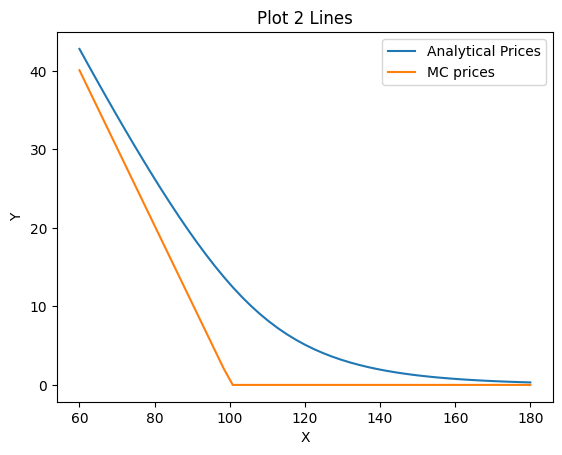

In [13]:
plt.plot(s_grid, analytical_prices, label='Analytical Prices')
plt.plot(s_grid, mc_prices, label='MC prices')

# Thêm nhãn
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot 2 Lines')
plt.legend()

# Hiển thị
plt.show()